In [ ]:
import os
import pandas as pd
from tqdm import tqdm
from sklearn.utils import resample
from PIL import Image, ImageFile
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.optim as optim
from torchvision.models import resnet50, ResNet50_Weights

# 允许加载截断的图像（可选，根据需要使用）
ImageFile.LOAD_TRUNCATED_IMAGES = True

# 设置CUDA设备
os.environ['CUDA_VISIBLE_DEVICES'] = '2'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def load_and_preprocess_data(data_path, image_save_dir):
    """
    加载数据集，验证图像完整性，过滤无效样本，并进行数据平衡。
    
    Args:
        data_path (str): 数据集Excel文件路径。
        image_save_dir (str): 图像保存目录路径。
    
    Returns:
        pd.DataFrame: 经过验证和平衡后的数据集。
    """
    # 加载数据集
    df = pd.read_excel(data_path)
    df = df.dropna(subset=['煤气灶图片地址'])  # 确保图像地址不为NaN
    
    # 添加原始索引作为新的列
    df = df.reset_index().rename(columns={'index': 'original_index'})
    
    # 确保有保存图片的目录
    os.makedirs(image_save_dir, exist_ok=True)
    
    def is_image_valid(image_path):
        try:
            with Image.open(image_path) as img:
                img.load()  # 完全加载图像数据以确保其完整性
            return True
        except (OSError, IOError) as e:
            print(f"Image validation failed for {image_path}: {e}")
            return False
    
    # 过滤出有效的图片，保留原始索引
    df_valid = df[df['original_index'].apply(
        lambda x: is_image_valid(os.path.join(image_save_dir, f'image_{x}.jpg'))
    )].reset_index(drop=True)
    
    print(f"Valid images after enhanced validation: {len(df_valid)}")
    
    # 打印标签分布
    print("是否合格.2 分布:")
    print(df_valid['是否合格.2'].value_counts())
    print("不合格原因.2 分布 (仅不合格样本):")
    print(df_valid[df_valid['是否合格.2'] == '不合格']['不合格原因.2'].value_counts())
    
    # 数据平衡：过采样少数类
    df_majority = df_valid[df_valid['是否合格.2'] == '不合格']
    df_minority = df_valid[df_valid['是否合格.2'] == '合格']
    
    df_minority_oversampled = resample(
        df_minority, 
        replace=True,  # 允许重复采样
        n_samples=len(df_majority),  # 使少数类数量与多数类相同
        random_state=42
    )
    
    # 组合多数类和过采样的少数类
    df_balanced = pd.concat([df_majority, df_minority_oversampled]).reset_index(drop=True)
    print(f"Balanced dataset size: {len(df_balanced)}")
    print("Balanced Label 1 distribution:")
    print(df_balanced['是否合格.2'].value_counts())
    
    # 确保“合格”样本的 '不合格原因.2' 为 'na'
    # 根据您的数据，调整为实际的NaN或特定字符串
    df_balanced.loc[df_balanced['是否合格.2'] == '合格', '不合格原因.2'] = 'na'
    
    # 移除任何“合格”样本中存在不合格原因的情况
    invalid_na = df_balanced[
        (df_balanced['是否合格.2'] == '合格') & 
        (df_balanced['不合格原因.2'] != 'na')
    ]
    
    if not invalid_na.empty:
        print(f"Found {len(invalid_na)} '合格' samples with invalid '不合格原因.2':")
        print(invalid_na)
        # 移除这些无效样本
        df_balanced = df_balanced.drop(invalid_na.index).reset_index(drop=True)
        print(f"Balanced dataset size after removing invalid '合格' samples: {len(df_balanced)}")
    else:
        print("All '合格' samples have no '不合格原因.2'.")
    
    return df_balanced

class GasStoveDataset(Dataset):
    def __init__(self, df, image_dir, transform=None, debug=False):
        """
        自定义数据集类。
        
        Args:
            df (pd.DataFrame): 数据集DataFrame。
            image_dir (str): 图像保存目录路径。
            transform (callable, optional): 图像转换函数。
            debug (bool, optional): 是否启用调试打印。
        """
        self.df = df
        self.image_dir = image_dir
        self.transform = transform
        self.debug = debug

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        original_index = self.df.iloc[idx]['original_index']
        image_path = os.path.join(self.image_dir, f'image_{original_index}.jpg')
        
        try:
            with Image.open(image_path) as img:
                image = img.convert("RGB")
                if self.transform:
                    image = self.transform(image)
        except (OSError, IOError) as e:
            print(f"Error loading image {image_path}: {e}")
            # 返回一个全黑图像作为占位符
            image = Image.new('RGB', (224, 224), (0, 0, 0))
            if self.transform:
                image = self.transform(image)

        # Label 1: 合格/不合格
        label_1 = 1 if self.df.iloc[idx]['是否合格.2'] == '合格' else 0

        # Label 2: 不合格原因
        if label_1 == 1:
            label_2 = 4  # 无不合格原因
        else:
            reason = self.df.iloc[idx]['不合格原因.2']
            if reason == '被挡住无法看出':
                label_2 = 0
            elif reason == '无熄火保护装置':
                label_2 = 1
            elif reason == '猛火灶':
                label_2 = 2
            elif reason == '模糊无法看出':
                label_2 = 3
            else:
                raise ValueError(f"Unrecognized reason '{reason}' at index {idx}")

        # # 调试打印
        # if self.debug and idx < 5:  # 仅打印前5个样本
        #     if label_1 == 1:
        #         print(f"Index {idx}: 合格, label_2 set to 4 (无不合格原因)")
        #     else:
        #         print(f"Index {idx}: 不合格, 原因: {reason}, label_2 set to {label_2}")

        return image, torch.tensor(label_1, dtype=torch.float), torch.tensor(label_2, dtype=torch.long)

def create_dataloaders(df, image_save_dir, transform, batch_size=16, num_workers=0):
    """
    划分数据集并创建DataLoader。
    
    Args:
        df (pd.DataFrame): 数据集DataFrame。
        image_save_dir (str): 图像保存目录路径。
        transform (callable): 图像转换函数。
        batch_size (int, optional): 批次大小。
        num_workers (int, optional): DataLoader的工作线程数。
    
    Returns:
        tuple: 训练集、验证集和测试集的DataLoader。
    """
    # 划分数据集
    train_val_df, test_df = train_test_split(
        df, 
        test_size=0.2, 
        random_state=42, 
        stratify=df['是否合格.2']
    )
    train_df, val_df = train_test_split(
        train_val_df, 
        test_size=0.2, 
        random_state=42, 
        stratify=train_val_df['是否合格.2']
    )

    # 打印数据集大小
    print(f"Train size: {len(train_df)}")
    print(f"Validation size: {len(val_df)}")
    print(f"Test size: {len(test_df)}")

    # 打印标签分布
    print("Train Label 1 distribution:")
    print(train_df['是否合格.2'].value_counts())
    print("Validation Label 1 distribution:")
    print(val_df['是否合格.2'].value_counts())
    print("Test Label 1 distribution:")
    print(test_df['是否合格.2'].value_counts())

    # 创建数据集
    train_dataset = GasStoveDataset(train_df, image_save_dir, transform=transform, debug=True)
    val_dataset = GasStoveDataset(val_df, image_save_dir, transform=transform, debug=False)
    test_dataset = GasStoveDataset(test_df, image_save_dir, transform=transform, debug=False)

    # 创建数据加载器
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

    return train_loader, val_loader, test_loader

def define_model(num_classes_reason=5):
    """
    定义并返回GasStoveClassifier模型。
    
    Args:
        num_classes_reason (int, optional): 不合格原因的类别数。
    
    Returns:
        nn.Module: 定义好的模型。
    """
    class GasStoveClassifier(nn.Module):
        def __init__(self, num_classes_reason=5):
            super(GasStoveClassifier, self).__init__()
            self.feature_extractor = resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
            self.feature_extractor.fc = nn.Identity()  # 移除最后一层
            
            self.classifier_1 = nn.Linear(2048, 1)  # Binary classifier for 合格/不合格
            self.classifier_2 = nn.Linear(2048, num_classes_reason)  # Multi-class classifier for 不合格原因

        def forward(self, x):
            features = self.feature_extractor(x)
            output_1 = torch.sigmoid(self.classifier_1(features))  # Binary output
            output_2 = self.classifier_2(features)  # Multi-class output
            return output_1, output_2
    
    model = GasStoveClassifier(num_classes_reason=num_classes_reason)
    return model

def compute_metrics(predictions, labels, threshold=0.5):
    """
    计算分类指标。
    
    Args:
        predictions (torch.Tensor): 模型的预测输出。
        labels (torch.Tensor): 真实标签。
        threshold (float, optional): 阈值，用于二分类。
    
    Returns:
        tuple: 精确度、召回率、F1分数和准确率。
    """
    preds = (predictions > threshold).float().cpu().numpy()
    labels = labels.cpu().numpy()
    precision = precision_score(labels, preds, average='binary', zero_division=0)
    recall = recall_score(labels, preds, average='binary', zero_division=0)
    f1 = f1_score(labels, preds, average='binary', zero_division=0)
    accuracy = accuracy_score(labels, preds)
    return precision, recall, f1, accuracy

def train_model(model, train_loader, val_loader, criterion_1, criterion_2, optimizer, epochs, device):
    """
    训练模型。
    
    Args:
        model (nn.Module): 要训练的模型。
        train_loader (DataLoader): 训练集的DataLoader。
        val_loader (DataLoader): 验证集的DataLoader。
        criterion_1 (nn.Module): 一级分类的损失函数。
        criterion_2 (nn.Module): 二级分类的损失函数。
        optimizer (torch.optim.Optimizer): 优化器。
        epochs (int): 训练的轮数。
        device (torch.device): 训练设备。
    
    Returns:
        None
    """
    best_val_f1 = 0.0  # 跟踪最佳验证F1分数以保存模型

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        train_metrics = {"precision": [], "recall": [], "f1": [], "accuracy": []}

        for batch_idx, (images, label_1, label_2) in enumerate(train_loader):
            # 调试：仅在前几个epoch和batch中打印标签
            if epoch < 1 and batch_idx < 1:
                print(f"Epoch {epoch+1}, Batch {batch_idx+1}")
                print(f"Label 1: {label_1.cpu().numpy()}")
                print(f"Label 2: {label_2.cpu().numpy()}")

            images = images.to(device)
            label_1 = label_1.to(device).unsqueeze(1)
            label_2 = label_2.to(device)

            optimizer.zero_grad()

            # 前向传播
            output_1, output_2 = model(images)
            loss_1 = criterion_1(output_1, label_1)
            loss_2 = criterion_2(output_2, label_2)

            # 计算总损失
            loss = loss_1 + loss_2  # CrossEntropyLoss 已经忽略 label_2=4 的样本

            # 反向传播
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

            # 计算指标
            precision, recall, f1, accuracy = compute_metrics(output_1, label_1)
            train_metrics["precision"].append(precision)
            train_metrics["recall"].append(recall)
            train_metrics["f1"].append(f1)
            train_metrics["accuracy"].append(accuracy)

        # 验证阶段
        model.eval()
        val_loss = 0.0
        val_metrics = {"precision": [], "recall": [], "f1": [], "accuracy": []}

        with torch.no_grad():
            for images, label_1, label_2 in val_loader:
                images = images.to(device)
                label_1 = label_1.to(device).unsqueeze(1)
                label_2 = label_2.to(device)

                output_1, output_2 = model(images)
                loss_1 = criterion_1(output_1, label_1)
                loss_2 = criterion_2(output_2, label_2)

                loss = loss_1 + loss_2

                val_loss += loss.item()

                # 计算指标
                precision, recall, f1, accuracy = compute_metrics(output_1, label_1)
                val_metrics["precision"].append(precision)
                val_metrics["recall"].append(recall)
                val_metrics["f1"].append(f1)
                val_metrics["accuracy"].append(accuracy)

        # 聚合指标
        avg_train_metrics = {k: sum(v)/len(v) for k, v in train_metrics.items()}
        avg_val_metrics = {k: sum(v)/len(v) for k, v in val_metrics.items()}

        print(f"Epoch {epoch+1}/{epochs}")
        print(f"Train Loss: {train_loss/len(train_loader):.4f}")
        print(f"Train Metrics: Precision: {avg_train_metrics['precision']:.4f}, Recall: {avg_train_metrics['recall']:.4f}, F1: {avg_train_metrics['f1']:.4f}, Accuracy: {avg_train_metrics['accuracy']:.4f}")
        print(f"Val Loss: {val_loss/len(val_loader):.4f}")
        print(f"Val Metrics: Precision: {avg_val_metrics['precision']:.4f}, Recall: {avg_val_metrics['recall']:.4f}, F1: {avg_val_metrics['f1']:.4f}, Accuracy: {avg_val_metrics['accuracy']:.4f}")

        # 保存最佳模型
        if avg_val_metrics["f1"] > best_val_f1:
            best_val_f1 = avg_val_metrics["f1"]
            torch.save(model.state_dict(), "best_gas_stove_model.pth")
            print("Saved Best Model!")

def evaluate_model(model, test_loader, compute_metrics_fn, device):
    """
    在测试集上评估模型性能。
    
    Args:
        model (nn.Module): 已训练的模型。
        test_loader (DataLoader): 测试集的DataLoader。
        compute_metrics_fn (callable): 计算指标的函数。
        device (torch.device): 评估设备。
    
    Returns:
        None
    """
    model.eval()
    test_metrics = {"precision": [], "recall": [], "f1": [], "accuracy": []}
    conf_matrix = None

    with torch.no_grad():
        for images, label_1, label_2 in test_loader:
            images = images.to(device)
            label_1 = label_1.to(device).unsqueeze(1)
            label_2 = label_2.to(device)

            output_1, output_2 = model(images)
            precision, recall, f1, accuracy = compute_metrics_fn(output_1, label_1)

            test_metrics["precision"].append(precision)
            test_metrics["recall"].append(recall)
            test_metrics["f1"].append(f1)
            test_metrics["accuracy"].append(accuracy)

            # 计算混淆矩阵
            preds = (output_1 > 0.5).float().cpu().numpy()
            labels = label_1.cpu().numpy()
            if conf_matrix is None:
                conf_matrix = confusion_matrix(labels, preds)
            else:
                conf_matrix += confusion_matrix(labels, preds)

            # 调试：打印样本预测
            print(f"Sample Predictions: {preds[:5]}")
            print(f"Sample Labels: {labels[:5]}")

    # 聚合测试指标
    avg_test_metrics = {k: sum(v)/len(v) for k, v in test_metrics.items()}
    print(f"Test Metrics: Precision: {avg_test_metrics['precision']:.4f}, Recall: {avg_test_metrics['recall']:.4f}, F1: {avg_test_metrics['f1']:.4f}, Accuracy: {avg_test_metrics['accuracy']:.4f}")

    # 打印混淆矩阵
    print("Confusion Matrix:")
    print(conf_matrix)

def show_images(dataset, num_images=8):
    """
    显示数据集中的图像网格。
    
    Args:
        dataset (Dataset): 数据集对象（例如，train_dataset, val_dataset）。
        num_images (int, optional): 显示的图像数量。
    
    Returns:
        None
    """
    # 获取一批图像和标签
    images, labels_1, labels_2 = zip(*[dataset[i] for i in range(num_images)])

    # 转换为网格
    images = torch.stack(images)  # 组合张量
    grid = make_grid(images, nrow=4, normalize=True, scale_each=True)

    # 绘制网格
    plt.figure(figsize=(12, 8))
    plt.imshow(grid.permute(1, 2, 0))  # 转换为HWC格式用于matplotlib
    plt.axis("off")
    plt.title("Sample Images with Labels")
    plt.show()

    # 显示标签
    for i in range(num_images):
        print(f"Image {i+1}: Label 1 (合格/不合格) = {labels_1[i].item()}, Label 2 (Reason) = {labels_2[i].item()}")


In [11]:

# 数据路径和图像保存目录
data_path = 'datasets.xlsx'
image_save_dir = 'gas_stove_images'

# 加载和预处理数据
df_balanced = load_and_preprocess_data(data_path, image_save_dir)



Valid images after enhanced validation: 7463
是否合格.2 分布:
是否合格.2
不合格    5943
合格     1518
Name: count, dtype: int64
不合格原因.2 分布 (仅不合格样本):
不合格原因.2
无熄火保护装置    3233
被挡住无法看出    2538
模糊无法看出      150
猛火灶          20
Name: count, dtype: int64
Balanced dataset size: 11886
Balanced Label 1 distribution:
是否合格.2
不合格    5943
合格     5943
Name: count, dtype: int64
Found 2 '不合格' samples with missing '不合格原因.2':
      original_index 燃气用户名称 用户类型  \
3277            3926    李春花   居民   
5106            6364    张孝妹   居民   

                                                 门窗图片地址  Unnamed: 3 是否合格  \
3277  http://jsxk-household-inspection.oss-cn-hangzh...         NaN   合格   
5106                                                NaN         NaN  NaN   

     不合格原因                                            调压器图片地址  Unnamed: 7  \
3277   NaN  http://jsxk-household-inspection.oss-cn-hangzh...         NaN   
5106   NaN  http://jsxk-household-inspection.oss-cn-hangzh...         NaN   

     是否合格.1 不合格原因.1                

In [12]:

# 图像转换
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# 创建DataLoader
train_loader, val_loader, test_loader = create_dataloaders(
    df_balanced, 
    image_save_dir, 
    transform, 
    batch_size=16, 
    num_workers=0
)


Train size: 7605
Validation size: 1902
Test size: 2377
Train Label 1 distribution:
是否合格.2
合格     3803
不合格    3802
Name: count, dtype: int64
Validation Label 1 distribution:
是否合格.2
不合格    951
合格     951
Name: count, dtype: int64
Test Label 1 distribution:
是否合格.2
合格     1189
不合格    1188
Name: count, dtype: int64


In [13]:
# 方法1：根据当前DataFrame的行索引
try:
    sample = df_balanced.iloc[3975]
    print("Sample at DataFrame index 3975:")
    print(sample)
except IndexError:
    print("Index 3975 is out of bounds for the DataFrame.")

# 方法2：根据原始索引
original_idx = 3975
sample = df_balanced[df_balanced['original_index'] == original_idx]
if not sample.empty:
    print(f"Sample with original_index {original_idx}:")
    print(sample.iloc[0])
else:
    print(f"No sample found with original_index {original_idx}.")

Sample at DataFrame index 3975:
original_index                                                 4856
燃气用户名称                                                          朱云芳
用户类型                                                             居民
门窗图片地址                                                          NaN
Unnamed: 3                                                      NaN
是否合格                                                            NaN
不合格原因                                                           NaN
调压器图片地址           http://jsxk-cylinder.oss-cn-hangzhou.aliyuncs....
Unnamed: 7                                                      NaN
是否合格.1                                                          不合格
不合格原因.1                                                       可调减压阀
煤气灶图片地址           http://jsxk-cylinder.oss-cn-hangzhou.aliyuncs....
Unnamed: 11                                                     NaN
是否合格.2                                                          不合格
不合格原因.2         

Index 0: 合格, label_2 set to 4 (无不合格原因)
Index 1: 不合格, 原因: 无熄火保护装置, label_2 set to 1
Index 2: 合格, label_2 set to 4 (无不合格原因)
Index 3: 不合格, 原因: 无熄火保护装置, label_2 set to 1
Index 4: 合格, label_2 set to 4 (无不合格原因)


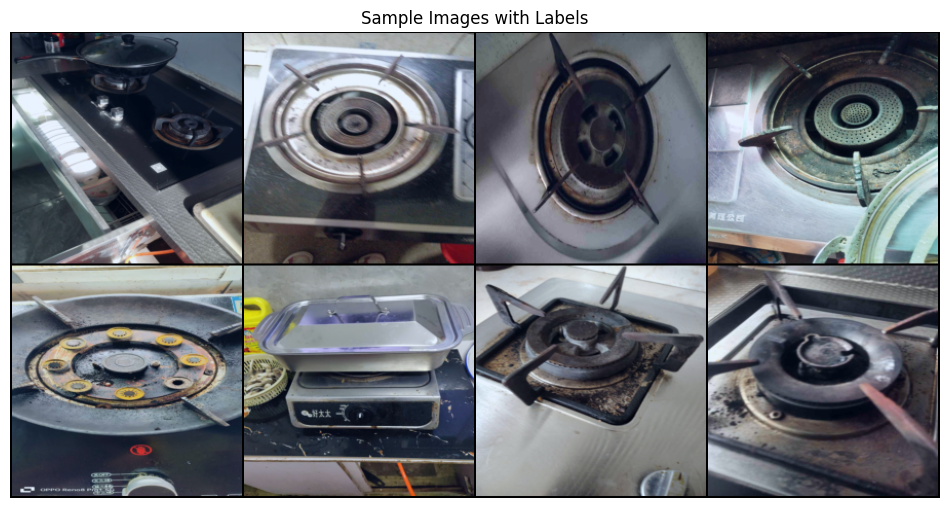

Image 1: Label 1 (合格/不合格) = 1.0, Label 2 (Reason) = 4
Image 2: Label 1 (合格/不合格) = 0.0, Label 2 (Reason) = 1
Image 3: Label 1 (合格/不合格) = 1.0, Label 2 (Reason) = 4
Image 4: Label 1 (合格/不合格) = 0.0, Label 2 (Reason) = 1
Image 5: Label 1 (合格/不合格) = 1.0, Label 2 (Reason) = 4
Image 6: Label 1 (合格/不合格) = 0.0, Label 2 (Reason) = 0
Image 7: Label 1 (合格/不合格) = 1.0, Label 2 (Reason) = 4
Image 8: Label 1 (合格/不合格) = 1.0, Label 2 (Reason) = 4


Epoch 1/10 - Training:   0%|          | 1/476 [00:03<31:21,  3.96s/it, f1=0, loss=2.43]

Epoch 1, Batch 1
Label 1: [0. 0. 0. 1. 1. 0. 0. 0. 1. 1. 0. 0. 0. 0. 1. 1.]
Label 2: [0 0 0 4 4 0 0 0 4 4 0 0 1 0 4 4]


Epoch 1/10 - Training:   6%|▌         | 27/476 [01:44<28:39,  3.83s/it, f1=0.9, loss=0.703]  

In [ ]:

# 可视化部分训练图像
show_images(train_loader.dataset, num_images=8)

# 定义模型
model = define_model(num_classes_reason=5)
model = model.to(device)

# 定义损失函数和优化器
criterion_1 = nn.BCELoss()  # 一级分类损失
criterion_2 = nn.CrossEntropyLoss(ignore_index=4)  # 二级分类损失，忽略label_2=4的样本
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# 训练模型
epochs = 10
train_model(
    model, 
    train_loader, 
    val_loader, 
    criterion_1, 
    criterion_2, 
    optimizer, 
    epochs, 
    device
)

# 加载最佳模型
model.load_state_dict(torch.load("best_gas_stove_model.pth"))

# 在测试集上评估模型
evaluate_model(model, test_loader, compute_metrics, device)

In [ ]:

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

# 自定义数据集
class GasStoveDataset(Dataset):
    def __init__(self, df, image_dir, transform=None):
        self.df = df
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        image_path = os.path.join(self.image_dir, f'image_{idx}.jpg')
        image = Image.open(image_path).convert("RGB")

        # 标签处理：一级标签（是否合格）
        label_1 = 1 if self.df.iloc[idx]['是否合格.2'] == '合格' else 0
        # 二级标签（不合格原因）
        reason = self.df.iloc[idx]['不合格原因.2']
        label_2 = 0 if reason == '被挡住无法看出' else 1  # 假设两个原因

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(label_1, dtype=torch.float), torch.tensor(label_2, dtype=torch.long)

# 图像增强
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# 加载数据集
dataset = GasStoveDataset(df, image_save_dir, transform=transform)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

(0       http://jsxk-household-inspection.oss-cn-hangzh...
 1       http://jsxk-household-inspection.oss-cn-hangzh...
 2       http://jsxk-household-inspection.oss-cn-hangzh...
 3       http://jsxk-cylinder.oss-cn-hangzhou.aliyuncs....
 4       http://jsxk-household-inspection.oss-cn-hangzh...
                               ...                        
 8053                                                  NaN
 8054                                                  NaN
 8055                                                  NaN
 8056                                                  NaN
 8057                                                  NaN
 Name: 煤气灶图片地址, Length: 8058, dtype: object,
 0       合格
 1       合格
 2       合格
 3       合格
 4       合格
         ..
 8053    合格
 8054    合格
 8055    合格
 8056    合格
 8057    合格
 Name: 是否合格, Length: 8058, dtype: object)

In [ ]:

# 可视化部分训练图像
show_images(train_loader.dataset, num_images=8)

# 定义模型
model = define_model(num_classes_reason=5)
model = model.to(device)

# 定义损失函数和优化器
criterion_1 = nn.BCELoss()  # 一级分类损失
criterion_2 = nn.CrossEntropyLoss(ignore_index=4)  # 二级分类损失，忽略label_2=4的样本
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# 训练模型
epochs = 10
train_model(
    model, 
    train_loader, 
    val_loader, 
    criterion_1, 
    criterion_2, 
    optimizer, 
    epochs, 
    device
)

# 加载最佳模型
model.load_state_dict(torch.load("best_gas_stove_model.pth"))

# 在测试集上评估模型
evaluate_model(model, test_loader, compute_metrics, device)

In [7]:
pip install openpyxl


  Using cached openpyxl-3.1.5-py2.py3-none-any.whl.metadata (2.5 kB)
Using cached openpyxl-3.1.5-py2.py3-none-any.whl (250 kB)
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models

class GasStoveClassifier(nn.Module):
    def __init__(self, num_classes_reason=2):
        super(GasStoveClassifier, self).__init__()
        self.feature_extractor = models.resnet50(pretrained=True)
        self.feature_extractor.fc = nn.Identity()  # Remove the last FC layer
        
        self.classifier_1 = nn.Linear(2048, 1)  # Binary classification: 合格/不合格
        self.classifier_2 = nn.Linear(2048, num_classes_reason)  # 多分类：不合格原因

    def forward(self, x):
        features = self.feature_extractor(x)
        output_1 = torch.sigmoid(self.classifier_1(features))
        output_2 = self.classifier_2(features)
        return output_1, output_2

In [ ]:
def custom_loss(output_1, output_2, label_1, label_2):
    loss_1 = nn.BCELoss()(output_1, label_1)
    loss_2 = nn.CrossEntropyLoss()(output_2, label_2)
    # 仅在不合格时计算 loss_2
    loss_2 = loss_2 * (label_1 == 0).float()
    return loss_1 + loss_2.mean()